In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime


from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob


In [2]:
from glob import glob


In [3]:
MASK_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.SubX/'
MASK_url1 = '/.hindcast/.pr'
MASK_url2 = '/dup/.SOURCES/.Features/.Political/.World/.Countries/.the_geom/objectid/135/VALUE/rasterize/dods'
url3 = '/Y/(23N)/(50N)/RANGEEDGES/X/(130W)/(60W)/RANGEEDGES'  

i_v_u ='EMC/.GEFS'
#                'GMAO/.GEOS_V2p1',
#                'NRL/.NESM',
#                'RSMAS/.CCSM4',
#                'NCEP/.CFSv2'
              #]

ds_mask = xr.open_dataset(MASK_url+i_v_u+MASK_url1+url3+MASK_url2)
ds_mask['the_geom']=xr.where(ds_mask.the_geom!=0, 1, 0)

ds_mask = ds_mask.rename({'X':'lon', 'Y':'lat'})
ds_mask = ds_mask.isel(objectid=0, drop=True)
ds_mask.coords['lon'] = ds_mask.lon+360.



# FITTING PROCEDURES

In [18]:
# Generate target time to check on L dependnece 
target_all = pd.date_range('1900-01-01', periods=365, freq='D')
target_all = [pd.DatetimeIndex([it]) for it in target_all]


In [11]:
# narr_clim_test_3d = xr.open_dataset('narr_clim_test_3d.nc')
# persiann_clim_test_3d = xr.open_dataset('persiann_clim_test_3d.nc')
# cpc_clim_test_3d = xr.open_dataset('cpc_clim_test_3d.nc')
ds_clim_test_3d = xr.open_dataset('ds_clim_test_3d_all_aug2020.nc')

# PERSIANN DATA

In [4]:
persiann_ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.CDR/.PERSIANN/.v01r01/.precipitation/Y/25/50/RANGE/X/230/300/RANGE/T/(1999)/(2016)/RANGEEDGES/dods')



In [5]:
persiann_ds = persiann_ds.rename({'T':'time','X':'lon','Y':'lat'})

In [6]:
persiann_ds

<xarray.Dataset>
Dimensions:        (lat: 102, lon: 282, time: 6575)
Coordinates:
  * lat            (lat) float32 24.875 25.125 25.375 ... 49.625 49.875 50.125
  * lon            (lon) float32 229.875 230.125 230.375 ... 299.875 300.125
  * time           (time) datetime64[ns] 1999-01-01T12:00:00 ... 2016-12-31T12:00:00
Data variables:
    precipitation  (time, lon, lat) float32 ...
Attributes:
    Conventions:  IRIDL

In [7]:
persiann_ds = persiann_ds.transpose('time','lat','lon')
persiann_ds

<xarray.Dataset>
Dimensions:        (lat: 102, lon: 282, time: 6575)
Coordinates:
  * lat            (lat) float32 24.875 25.125 25.375 ... 49.625 49.875 50.125
  * lon            (lon) float32 229.875 230.125 230.375 ... 299.875 300.125
  * time           (time) datetime64[ns] 1999-01-01T12:00:00 ... 2016-12-31T12:00:00
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [9]:
import xesmf as xe


In [10]:
temppersiann = persiann_ds.rolling(time=3, center=False).sum()
temppersiann.coords['time'] = temppersiann.time.values-np.timedelta64(2,'D')

In [12]:
temppersiann

<xarray.Dataset>
Dimensions:        (lat: 102, lon: 282, time: 6575)
Coordinates:
  * lat            (lat) float32 24.875 25.125 25.375 ... 49.625 49.875 50.125
  * lon            (lon) float32 229.875 230.125 230.375 ... 299.875 300.125
  * time           (time) datetime64[ns] 1998-12-30T12:00:00 ... 2016-12-29T12:00:00
Data variables:
    precipitation  (time, lat, lon) float32 nan nan nan ... 10.913296 13.459204

In [13]:
ds_out =ds_clim_test_3d[['lon','lat']]
ds_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    *empty*

In [14]:
regridderp = xe.Regridder(temppersiann, ds_out, 'bilinear')
regridderp

Overwrite existing file: bilinear_102x282_28x71.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_102x282_28x71.nc 
Reuse pre-computed weights? False 
Input grid shape:           (102, 282) 
Output grid shape:          (28, 71) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [15]:
persiann_out = regridderp(temppersiann)


using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.


In [16]:
persiann_out

<xarray.Dataset>
Dimensions:        (lat: 28, lon: 71, time: 6575)
Coordinates:
  * time           (time) datetime64[ns] 1998-12-30T12:00:00 ... 2016-12-29T12:00:00
  * lon            (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat            (lat) float32 50.0 49.0 48.0 47.0 ... 26.0 25.0 24.0 23.0
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [ ]:
def f(x): 
    return np.int(x)
f2 = np.vectorize(f) 

In [54]:
# looping through the target dates for climatologies
persiann_clim_test_3d = []
for iT in target_all:
    persiann_mid_w=[]
    for iw in np.array([3,7,15]):
        # adding iw days before and after
        iTa = iT-np.timedelta64(iw,'D')
        iTb = iT+np.timedelta64(iw,'D')
    #     temp = persiann_out.where((persiann_out.time.dt.month==iT.month.values[0])&
    #                         (persiann_out.time.dt.day==iT.day.values[0]), drop=True)
        ya = f2((persiann_out.time.dt.dayofyear>=iTa.dayofyear.values).values)
        yb = f2((persiann_out.time.dt.dayofyear<=iTb.dayofyear.values).values)
        wherevalues = ya+yb
        if wherevalues.max()==1:
            temp = persiann_out.sel(time=(wherevalues==1))
        elif wherevalues.max()==2:
            temp = persiann_out.sel(time=(wherevalues==2))
        temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
        persiann_quantile = temp*1.
        persiann_quantile = persiann_quantile.expand_dims('window')
        persiann_quantile.coords['window'] = 'window', np.atleast_1d(iw*2+1)
        persiann_mid_w.append(persiann_quantile)
    persiann_quantile = xr.combine_by_coords(persiann_mid_w)
    persiann_quantile = persiann_quantile.expand_dims('target_clim')
    persiann_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    persiann_clim_test_3d.append(persiann_quantile)
persiann_clim_test_3d = xr.combine_by_coords(persiann_clim_test_3d)    


In [65]:
persiann_clim_test_3d = persiann_clim_test_3d.rename({'quantile':'quant'})


persiann_clim_test_3d = persiann_clim_test_3d.rename({'precipitation':'apcp'})


In [66]:
persiann_clim_test_3d.to_netcdf('persiann_clim_test_3d_aug2020.nc')

In [67]:
import cmocean
cmap = cmocean.cm.deep


/local/ERAin/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


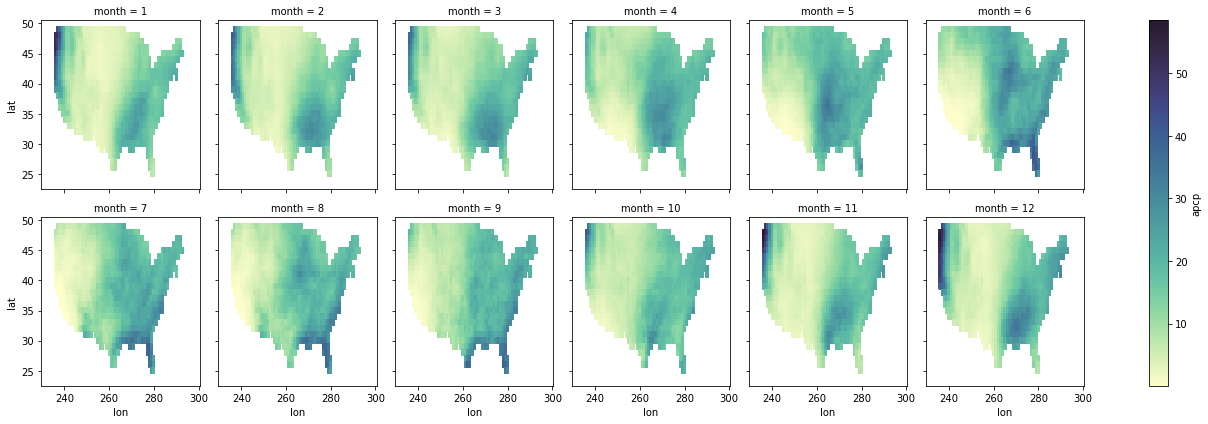

In [77]:
persiann_clim_test_3d.apcp[:,0,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

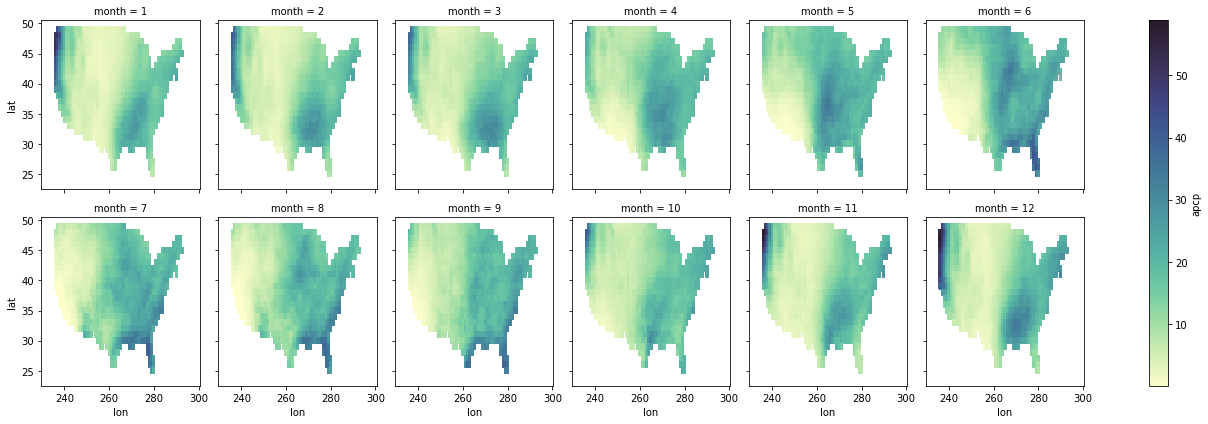

In [78]:
persiann_clim_test_3d.apcp[:,1,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

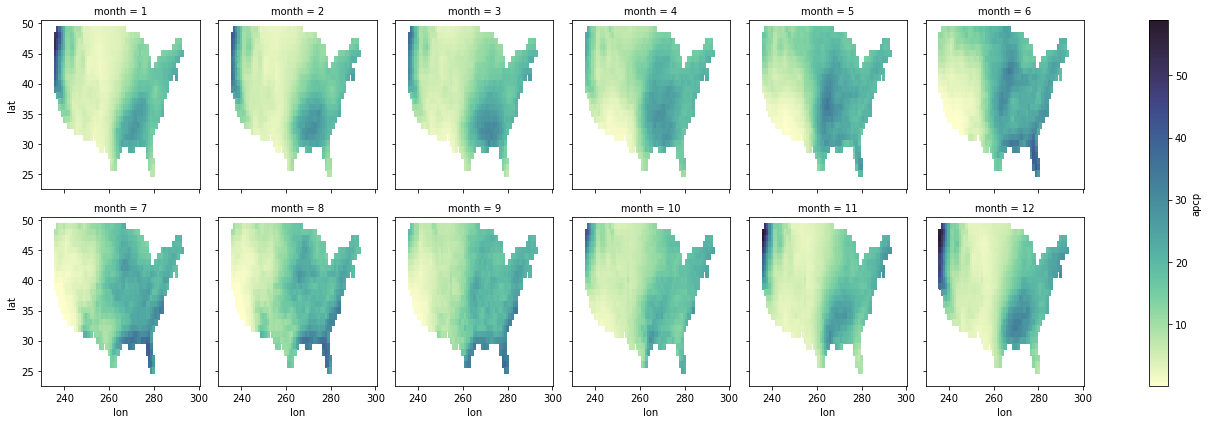

In [79]:
persiann_clim_test_3d.apcp[:,2,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

# CPC

In [55]:
cpc1 = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.CONUS/.v1p0/.RETRO/.rain/Y/25/50/RANGE/T/(1999)/(2006)/RANGEEDGES/dods')
cpc2 = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.CONUS/.v1p0/.REALTIME/.rain/Y/25/50/RANGE/T/(2007)/(2016)/RANGEEDGES/dods')


In [56]:
cpc1 = cpc1.rename({'T':'time','X':'lon','Y':'lat'})
cpc2 = cpc2.rename({'T':'time','X':'lon','Y':'lat'})


In [57]:
cpc1.coords['lon'] = cpc1.lon.values+360
cpc2.coords['lon'] = cpc2.lon.values+360

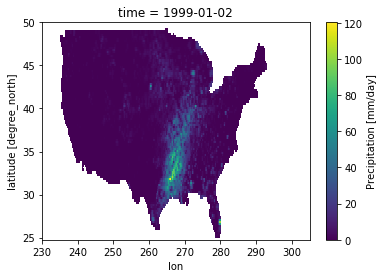

In [58]:
cpc1.rain[0].plot()

In [59]:
regridderc = xe.Regridder(cpc2, ds_out, 'bilinear')
regridderc

Overwrite existing file: bilinear_101x300_28x71.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_101x300_28x71.nc 
Reuse pre-computed weights? False 
Input grid shape:           (101, 300) 
Output grid shape:          (28, 71) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [60]:
cpc1_out = regridderc(cpc1)
cpc2_out = regridderc(cpc2)


using dimensions ('lat', 'lon') from data variable rain as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable rain as the horizontal dimensions for this dataset.


In [61]:
cpc1_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71, time: 2921)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-02 1999-01-03 ... 2006-12-31
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    rain     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [62]:
cpc_out = xr.combine_by_coords([cpc1_out, cpc2_out])

In [63]:
cpc_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71, time: 6573)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * time     (time) datetime64[ns] 1999-01-02 1999-01-03 ... 2016-12-31
Data variables:
    rain     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [64]:
cpc_out = cpc_out.rolling(time=3, center=False).sum()
cpc_out.coords['time'] = cpc_out.time.values-np.timedelta64(2,'D')

In [80]:
# # looping through the target dates for climatologies
# cpc_clim_test_3d = []
# for iT in target:
#     # extract values exact values
#     temp = cpc_out.where((cpc_out.time.dt.month==iT.month.values[0])&
#                         (cpc_out.time.dt.day==iT.day.values[0]), drop=True)
#     temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
#     cpc_quantile = temp*1.
#     cpc_quantile = cpc_quantile.expand_dims('window')
#     cpc_quantile.coords['window'] = 'window', np.atleast_1d(1)
#     # adding 2 days before and after
#     temp1 = cpc_out.where((cpc_out.time.dt.month==iT.month.values[0])&
#                         ((cpc_out.time.dt.day>=iT.day.values[0]-2)&(cpc_out.time.dt.day<=iT.day.values[0]+2)), 
#                           drop=True)

#     temp1 = temp1.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
#     temp1 = temp1.expand_dims('window')
#     temp1.coords['window'] = 'window', np.atleast_1d(5)
#     cpc_quantile = xr.merge([cpc_quantile, temp1])
#     cpc_quantile = cpc_quantile.expand_dims('target_clim')
#     cpc_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
#     cpc_clim_test_3d.append(cpc_quantile)
# cpc_clim_test_3d = xr.combine_by_coords(cpc_clim_test_3d)    


In [90]:
# looping through the target dates for climatologies
cpc_clim_test_3d = []
for iT in target_all:
    cpc_mid_w=[]
    for iw in np.array([3,7,15]):
        # adding iw days before and after
        iTa = iT-np.timedelta64(iw,'D')
        iTb = iT+np.timedelta64(iw,'D')
    #     temp = cpc_out.where((cpc_out.time.dt.month==iT.month.values[0])&
    #                         (cpc_out.time.dt.day==iT.day.values[0]), drop=True)
        ya = f2((cpc_out.time.dt.dayofyear>=iTa.dayofyear.values).values)
        yb = f2((cpc_out.time.dt.dayofyear<=iTb.dayofyear.values).values)
        wherevalues = ya+yb
        if wherevalues.max()==1:
            temp = cpc_out.sel(time=(wherevalues==1))
        elif wherevalues.max()==2:
            temp = cpc_out.sel(time=(wherevalues==2))
        temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
        cpc_quantile = temp*1.
        cpc_quantile = cpc_quantile.expand_dims('window')
        cpc_quantile.coords['window'] = 'window', np.atleast_1d(iw*2+1)
        cpc_mid_w.append(cpc_quantile)
    cpc_quantile = xr.combine_by_coords(cpc_mid_w)
    cpc_quantile = cpc_quantile.expand_dims('target_clim')
    cpc_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    cpc_clim_test_3d.append(cpc_quantile)
cpc_clim_test_3d = xr.combine_by_coords(cpc_clim_test_3d)    


/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/local/ERAin/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice enc

In [89]:
cpc_clim_test_3d

[<xarray.Dataset>
 Dimensions:      (lat: 28, lon: 71, quantile: 5, target_clim: 1, window: 3)
 Coordinates:
   * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
   * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
   * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
   * window       (window) int64 7 15 31
   * target_clim  (target_clim) datetime64[ns] 1900-01-01
 Data variables:
     rain         (target_clim, window, quantile, lat, lon) float64 0.0 ... 0.0,
 <xarray.Dataset>
 Dimensions:      (lat: 28, lon: 71, quantile: 5, target_clim: 1, window: 3)
 Coordinates:
   * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
   * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
   * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
   * window       (window) int64 7 15 31
   * target_clim  (target_clim) datetime64[ns] 1900-01-02
 Data variables:
     rain         (target_c

In [91]:
cpc_clim_test_3d = cpc_clim_test_3d.rename({'quantile':'quant'})


cpc_clim_test_3d = cpc_clim_test_3d.rename({'rain':'apcp'})


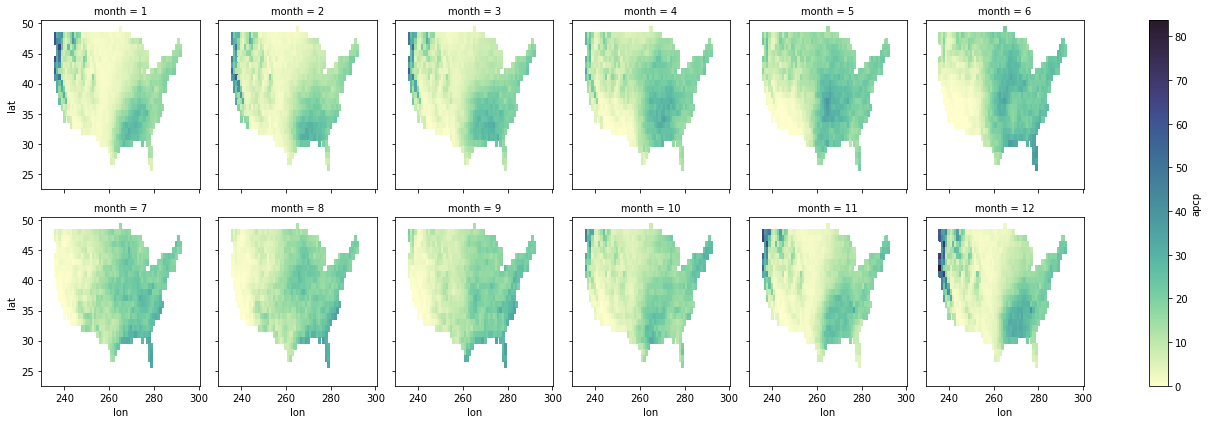

In [93]:
cpc_clim_test_3d.apcp[:,0,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

/local/ERAin/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


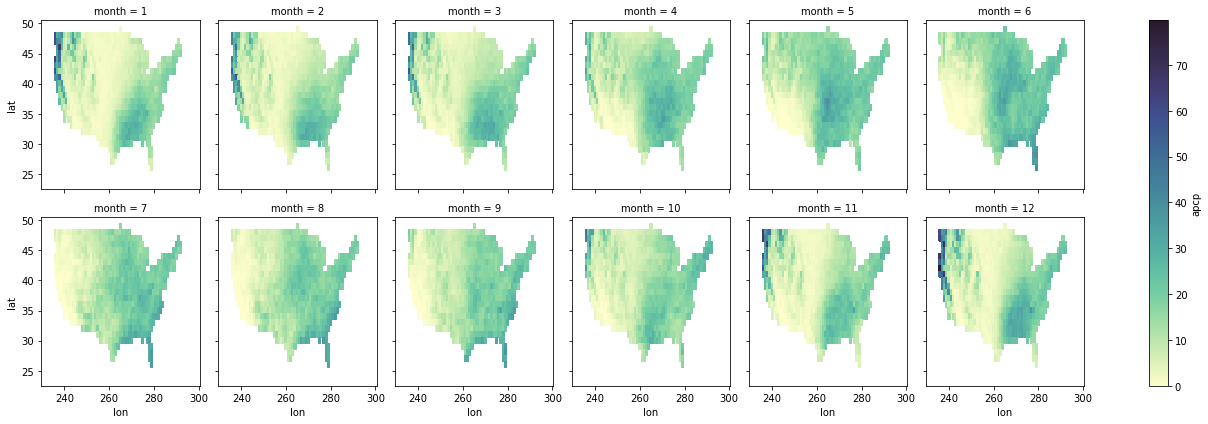

In [92]:
cpc_clim_test_3d.apcp[:,1,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

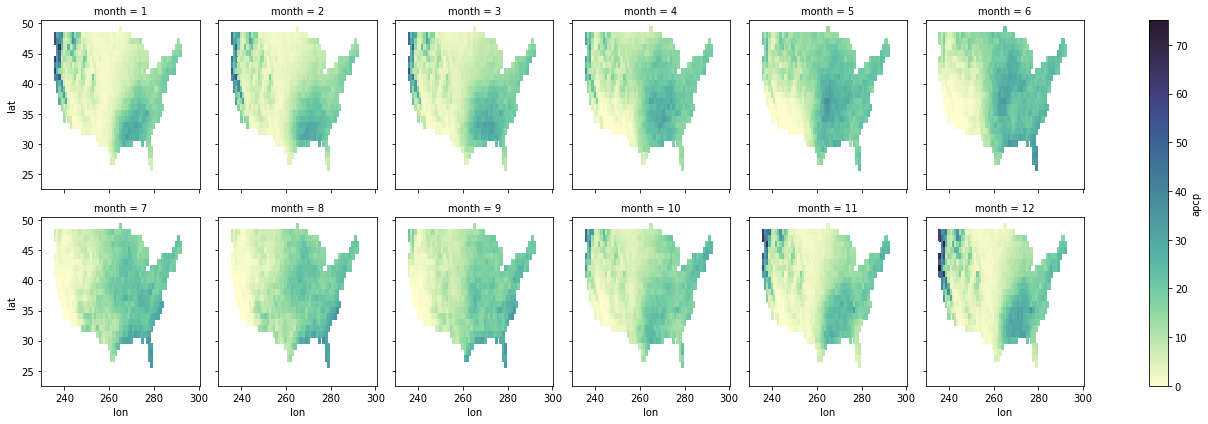

In [94]:
cpc_clim_test_3d.apcp[:,2,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

In [96]:
cpc_clim_test_3d

<xarray.Dataset>
Dimensions:      (lat: 28, lon: 71, quant: 5, target_clim: 365, window: 3)
Coordinates:
  * quant        (quant) float64 0.15 0.33 0.5 0.667 0.85
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * window       (window) int64 7 15 31
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    apcp         (target_clim, window, quant, lat, lon) float64 0.0 0.0 ... 0.0

In [99]:
cpc_clim_test_3d

<xarray.Dataset>
Dimensions:      (lat: 28, lon: 71, quant: 5, target_clim: 365, window: 3)
Coordinates:
  * quant        (quant) float64 0.15 0.33 0.5 0.667 0.85
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * window       (window) int64 7 15 31
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    apcp         (target_clim, window, quant, lat, lon) float64 0.0 0.0 ... 0.0

In [104]:
smooth_clim_cauchy = xr.open_dataset('smooth_clim_cauchy_aug2020.nc')

In [106]:
smooth_clim_cauchy

<xarray.Dataset>
Dimensions:      (Lbeg: 6, lat: 28, lon: 71, target_clim: 365)
Coordinates:
  * Lbeg         (Lbeg) object '14-33' '4-12' '4-22' '4-33' '6-14' '8-16'
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, lat, lon) float64 ...

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


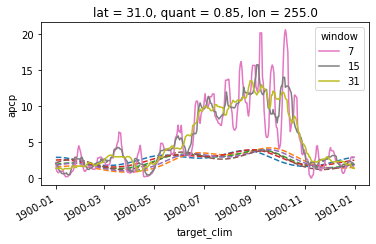

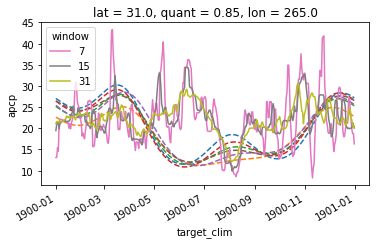

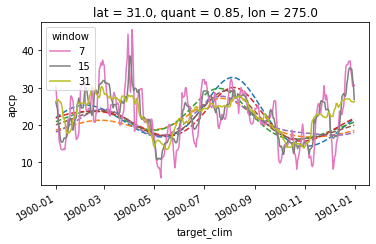

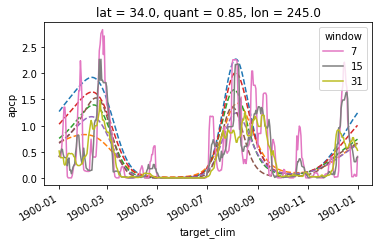

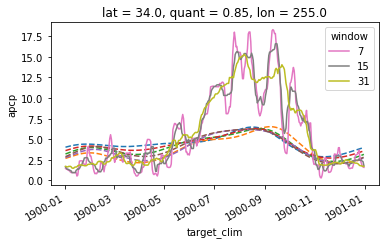

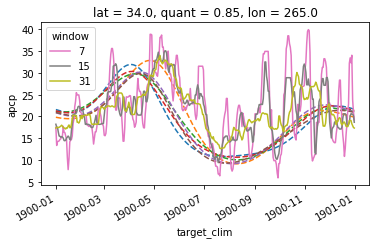

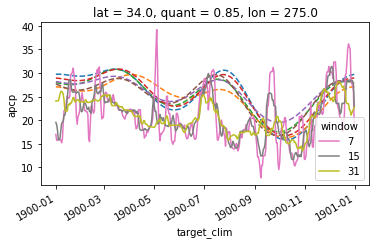

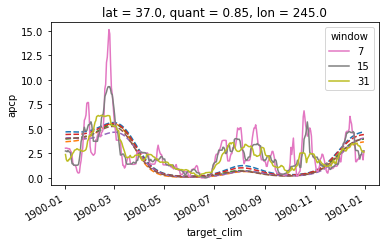

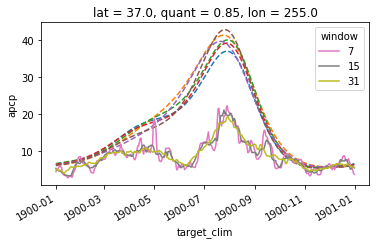

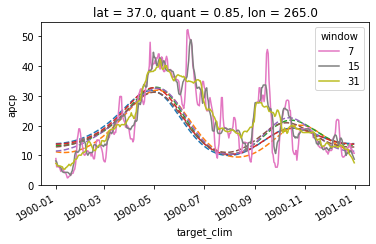

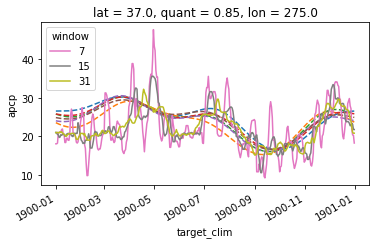

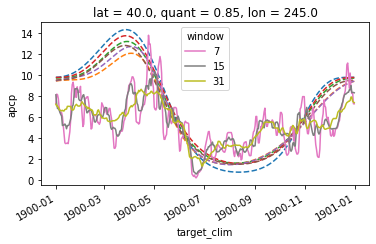

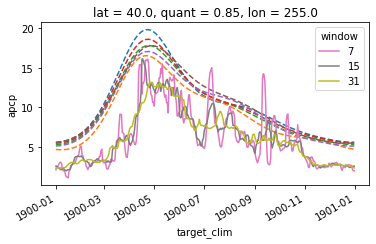

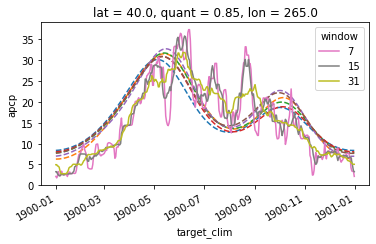

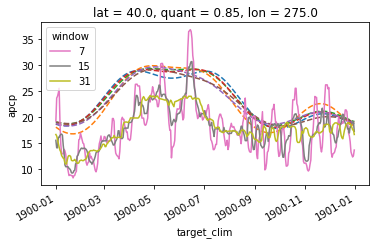

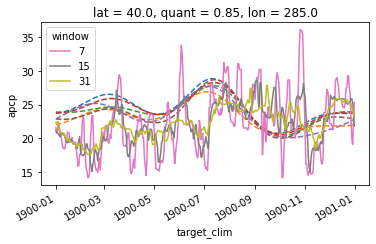

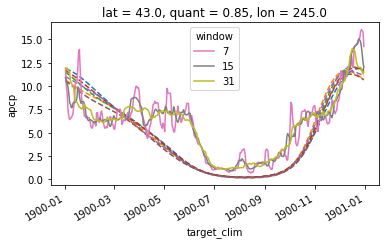

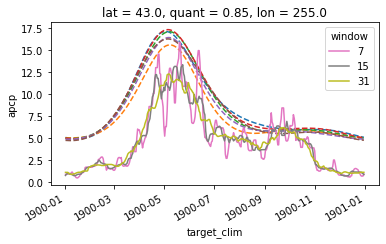

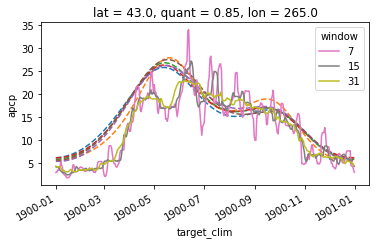

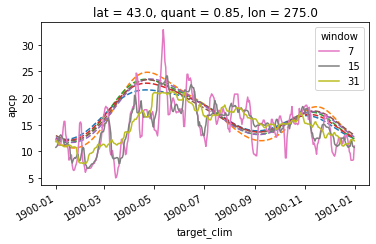

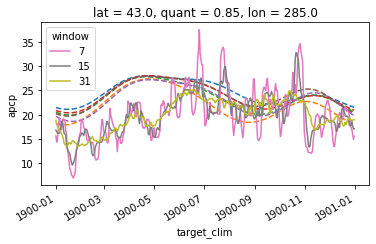

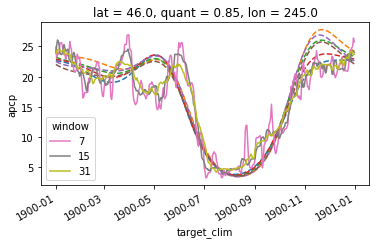

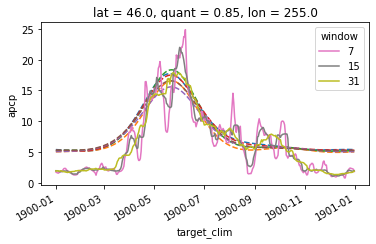

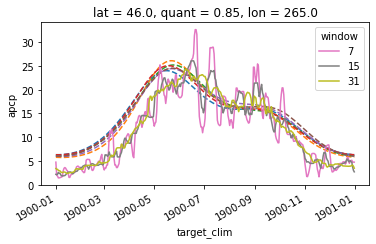

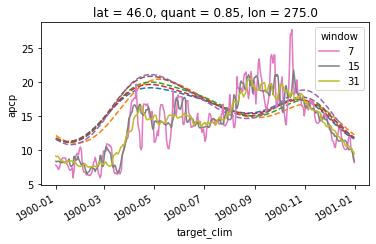

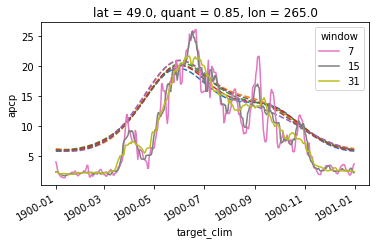

In [109]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        if np.sum(np.isnan(cpc_clim_test_3d.where(ds_mask.the_geom>0).apcp[:,:,-1,:,:].sel(lat=ilat, lon=ilon).values))==0:
            plt.figure(figsize=(20,3))
            ax = plt.subplot(131)
            smooth_clim_cauchy.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim')
            cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).sel(lat=ilat, lon=ilon).plot.line(ax=ax, x='target_clim')


In [95]:
cpc_clim_test_3d.to_netcdf('cpc_clim_test_3d_aug2020.nc')

# NARR data

In [110]:
narr_ls=[]
for iy in np.arange(1999, 2017):
    temp = xr.open_dataset('/crunch/c0/NARR/3_hr_all/apcp/apcp.'+np.str(iy)+'.nc',
                          drop_variables='Lambert_Conformal')
    # aggregate to daily
    temp = temp.resample(time='1D').sum()
#     print(temp)
#     pause
    narr_ls.append(temp)
    del temp

/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.

### combine, roll sum, roll back startign interval date

In [111]:
temp_latlon = narr_ls[0][['lat','lon']]
temp_latlon

<xarray.Dataset>
Dimensions:  (x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
    lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
Data variables:
    *empty*

In [112]:
narr_ds = xr.combine_by_coords(narr_ls)

### for some reason hte combining creates a dimension time for lon (might be small differences in decimal values). So I drop it and substitute with one only

In [113]:
narr_ds

<xarray.Dataset>
Dimensions:  (time: 6575, x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
    lon      (time, y, x) float32 -145.5 -145.315 ... 357.35638 357.4301
Data variables:
    apcp     (time, y, x) float64 0.001682 0.001682 0.001682 ... 0.0 0.0 0.0

In [114]:
narr_ds = narr_ds.drop('lon')

In [115]:
narr_ds.coords['lon']=temp_latlon.lon


In [116]:
narr_ds

<xarray.Dataset>
Dimensions:  (time: 6575, x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
    lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
Data variables:
    apcp     (time, y, x) float64 0.001682 0.001682 0.001682 ... 0.0 0.0 0.0

In [117]:
tempnarr = narr_ds.rolling(time=3, center=False).sum()
tempnarr.coords['time'] = tempnarr.time.values-np.timedelta64(2,'D')

In [118]:
import xesmf as xe
tempnarr = tempnarr.drop(['x','y'])
ds_out =ds_clim_test_3d[['lat','lon']]

In [119]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71)
Coordinates:
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
Data variables:
    *empty*

In [120]:
narr_ds

<xarray.Dataset>
Dimensions:  (time: 6575, x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
    lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
Data variables:
    apcp     (time, y, x) float64 0.001682 0.001682 0.001682 ... 0.0 0.0 0.0

In [121]:
regridder = xe.Regridder(tempnarr, ds_out, 'bilinear')
narr_out = regridder(tempnarr)


Overwrite existing file: bilinear_277x349_28x71.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('y', 'x') from data variable apcp as the horizontal dimensions for this dataset.


In [122]:
narr_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71, time: 6575)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-30 1998-12-31 ... 2016-12-29
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    apcp     (time, lat, lon) float64 nan nan nan nan ... 2.049 0.358 1.405
Attributes:
    regrid_method:  bilinear

In [123]:
# looping through the target dates for climatologies
narr_clim_test_3d = []
for iT in target_all:
    narr_mid_w=[]
    for iw in np.array([3,7,15]):
        # adding iw days before and after
        iTa = iT-np.timedelta64(iw,'D')
        iTb = iT+np.timedelta64(iw,'D')
    #     temp = narr_out.where((narr_out.time.dt.month==iT.month.values[0])&
    #                         (narr_out.time.dt.day==iT.day.values[0]), drop=True)
        ya = f2((narr_out.time.dt.dayofyear>=iTa.dayofyear.values).values)
        yb = f2((narr_out.time.dt.dayofyear<=iTb.dayofyear.values).values)
        wherevalues = ya+yb
        if wherevalues.max()==1:
            temp = narr_out.sel(time=(wherevalues==1))
        elif wherevalues.max()==2:
            temp = narr_out.sel(time=(wherevalues==2))
        temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
        narr_quantile = temp*1.
        narr_quantile = narr_quantile.expand_dims('window')
        narr_quantile.coords['window'] = 'window', np.atleast_1d(iw*2+1)
        narr_mid_w.append(narr_quantile)
    narr_quantile = xr.combine_by_coords(narr_mid_w)
    narr_quantile = narr_quantile.expand_dims('target_clim')
    narr_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    narr_clim_test_3d.append(narr_quantile)
narr_clim_test_3d = xr.combine_by_coords(narr_clim_test_3d)    


In [124]:
narr_clim_test_3d

<xarray.Dataset>
Dimensions:      (lat: 28, lon: 71, quantile: 5, target_clim: 365, window: 3)
Coordinates:
  * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * window       (window) int64 7 15 31
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    apcp         (target_clim, window, quantile, lat, lon) float64 3.24 ... 3.94

In [125]:
narr_clim_test_3d = narr_clim_test_3d.rename({'quantile':'quant'})


/local/ERAin/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


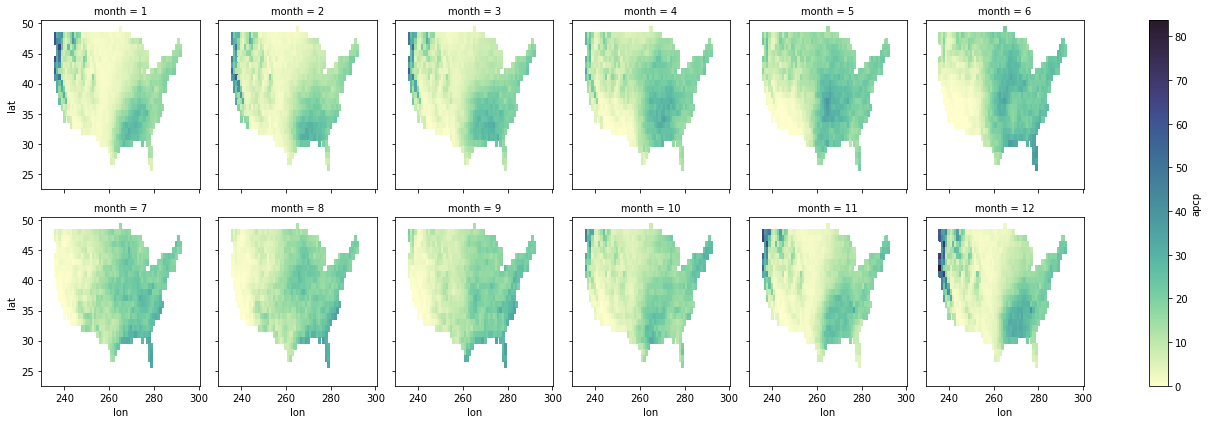

In [126]:
cpc_clim_test_3d.apcp[:,0,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

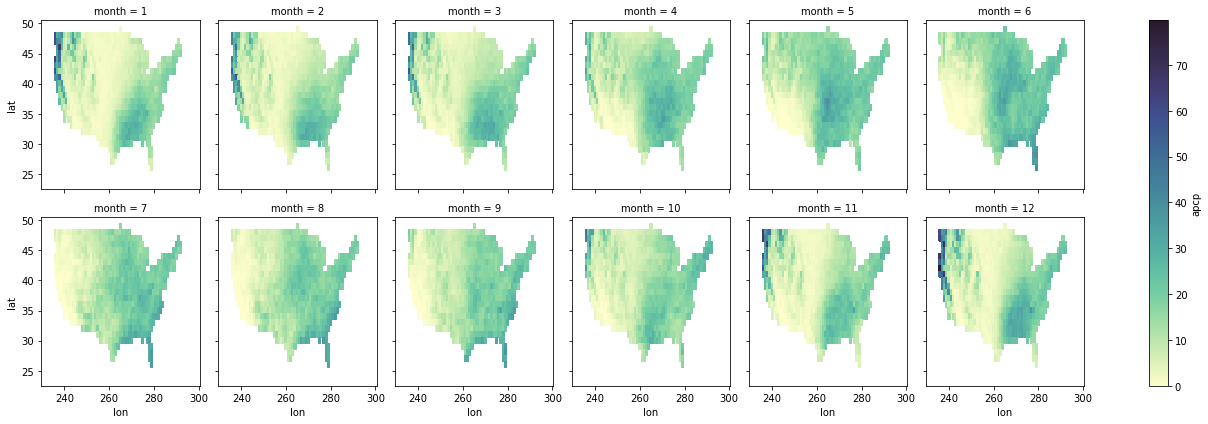

In [127]:
cpc_clim_test_3d.apcp[:,1,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

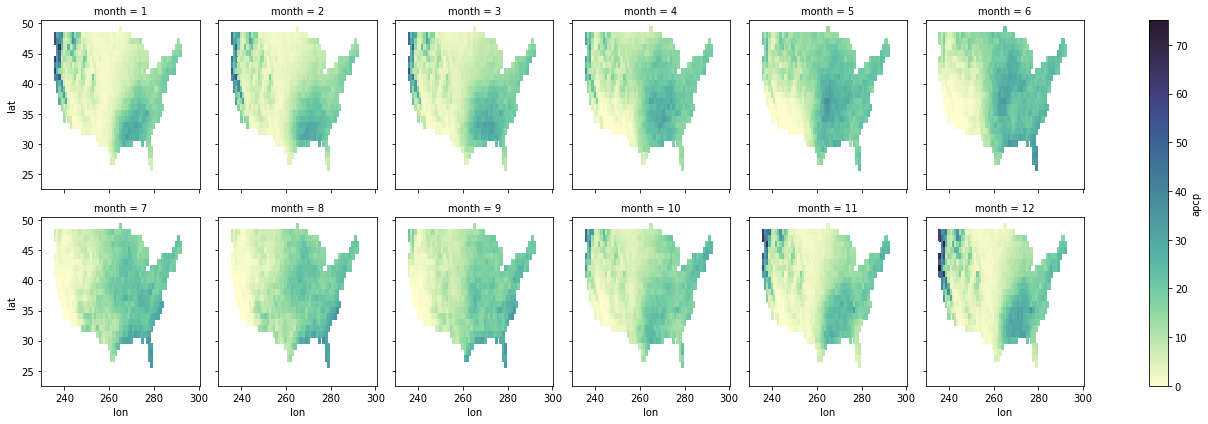

In [128]:
cpc_clim_test_3d.apcp[:,2,-1].where(ds_mask.the_geom>0).groupby('target_clim.month').mean().plot(col='month',col_wrap=6, cmap=cmap)

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


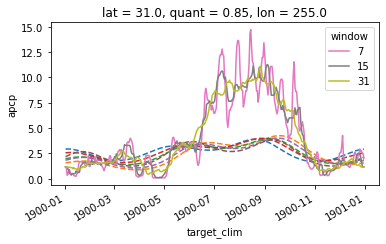

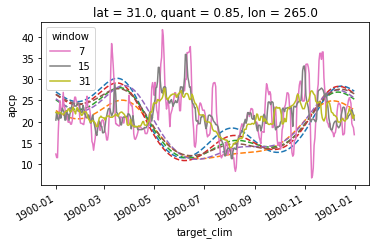

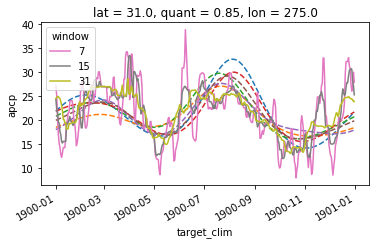

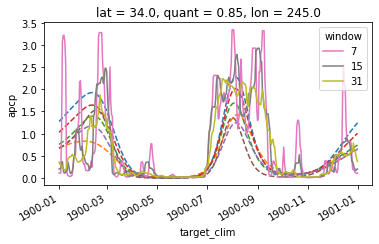

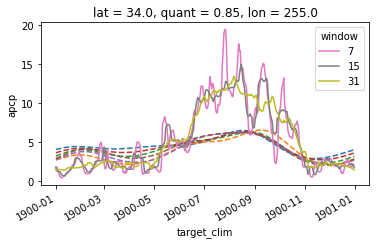

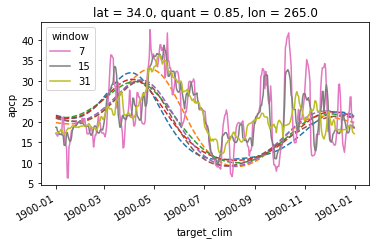

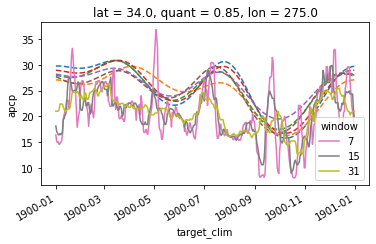

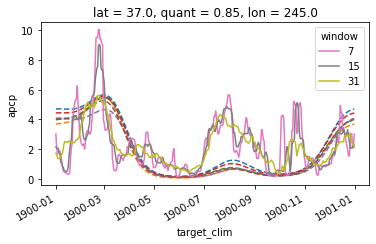

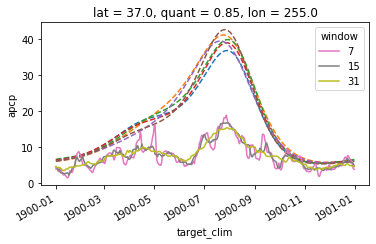

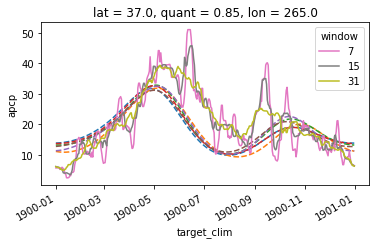

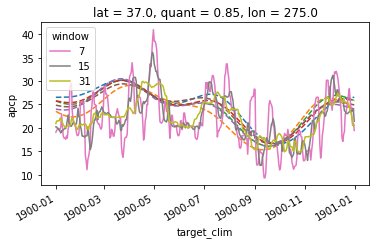

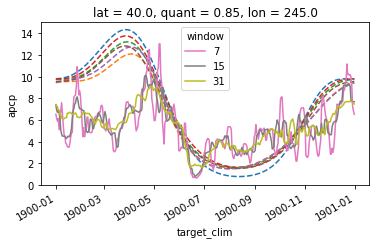

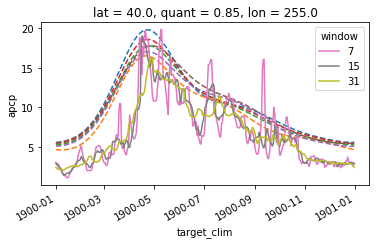

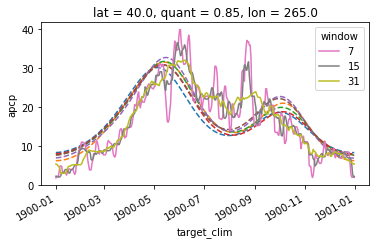

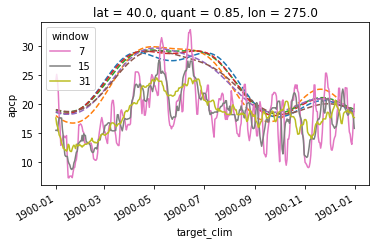

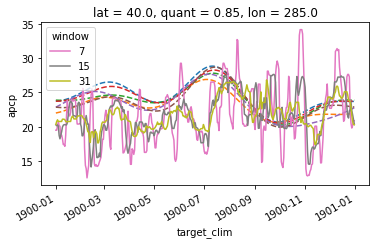

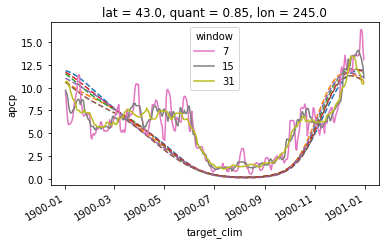

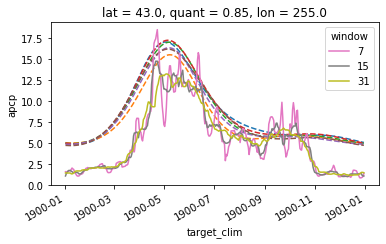

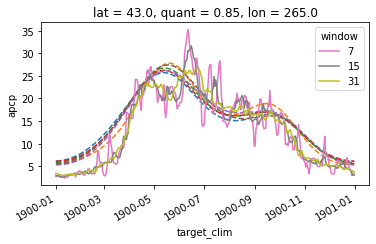

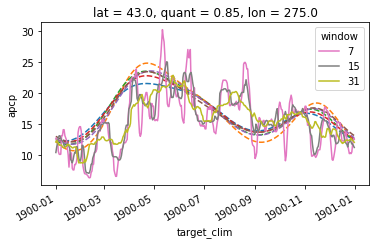

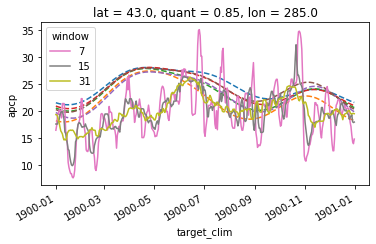

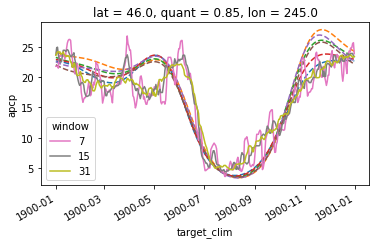

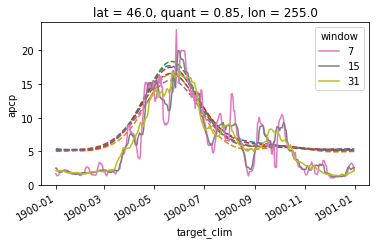

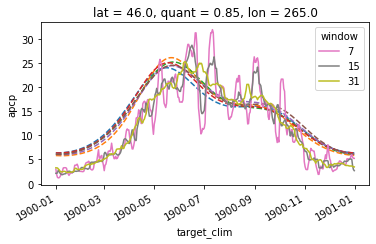

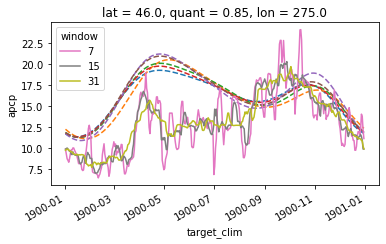

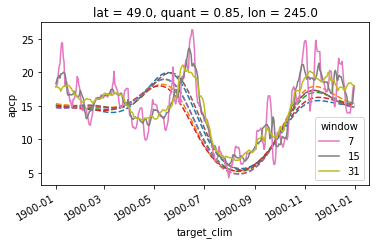

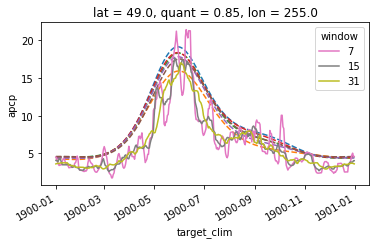

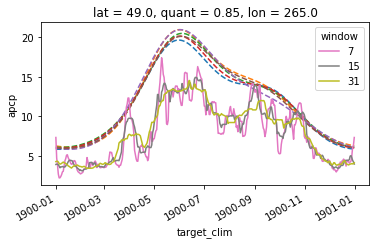

In [129]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        if np.sum(np.isnan(narr_clim_test_3d.where(ds_mask.the_geom>0).apcp[:,:,-1,:,:].sel(lat=ilat, lon=ilon).values))==0:
            plt.figure(figsize=(20,3))
            ax = plt.subplot(131)
            smooth_clim_cauchy.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim')
            narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).sel(lat=ilat, lon=ilon).plot.line(ax=ax, x='target_clim')


In [133]:
narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).shape

(365, 3, 28, 71)

In [131]:
narr_clim_test_3d.to_netcdf('narr_clim_test_3d_aug2020.nc')

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


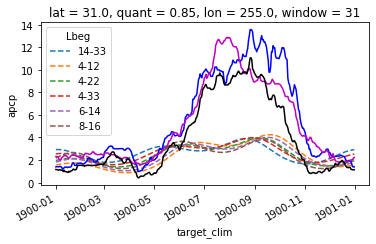

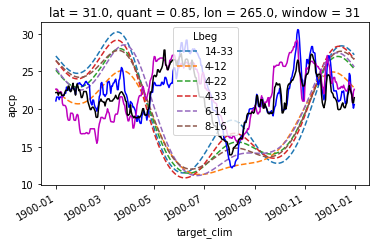

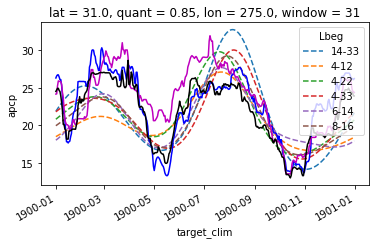

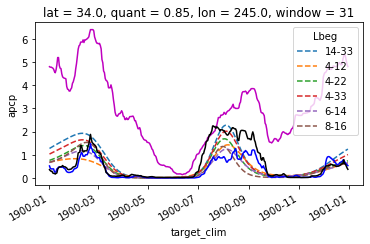

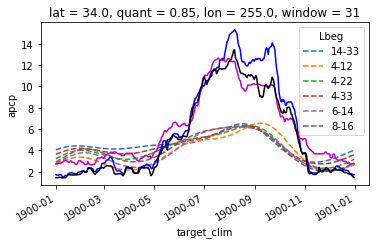

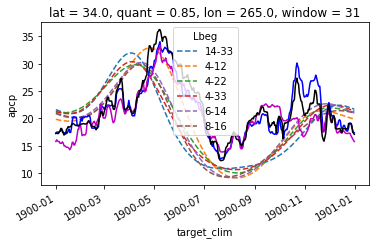

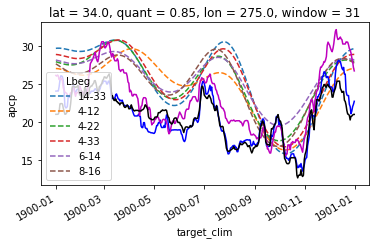

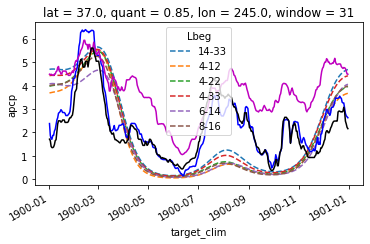

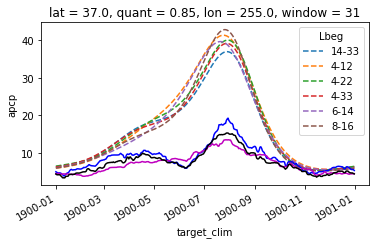

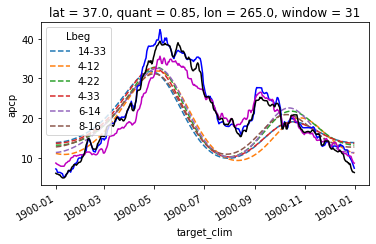

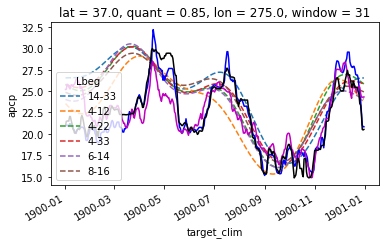

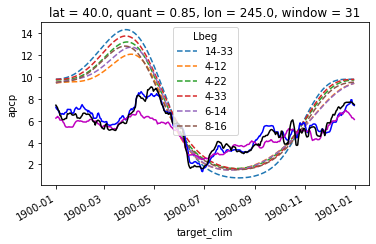

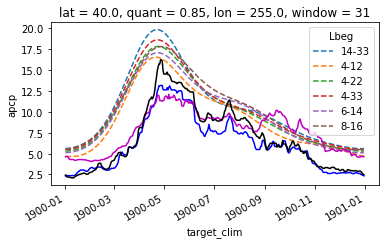

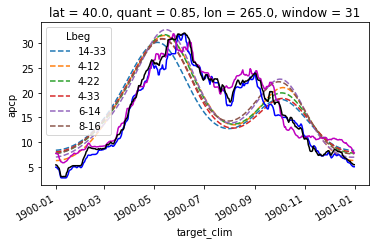

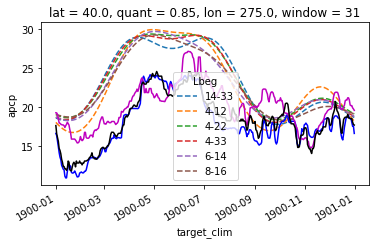

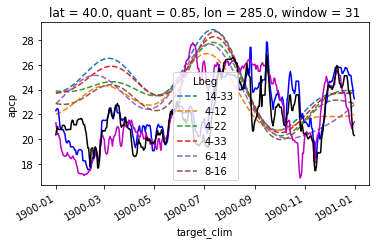

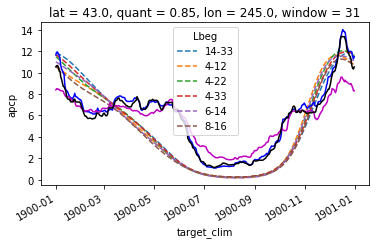

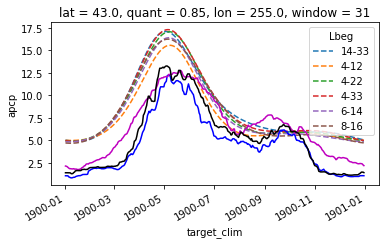

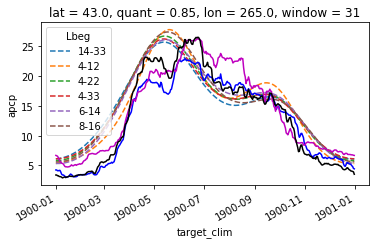

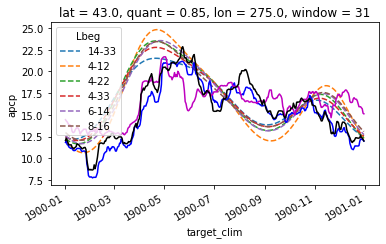

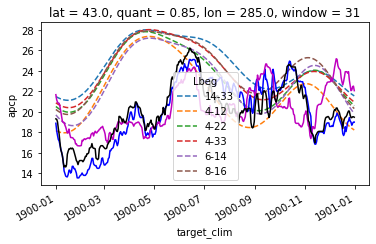

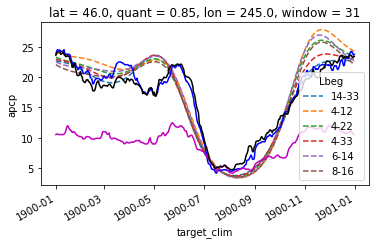

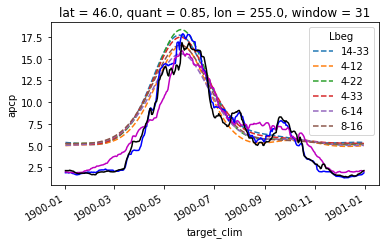

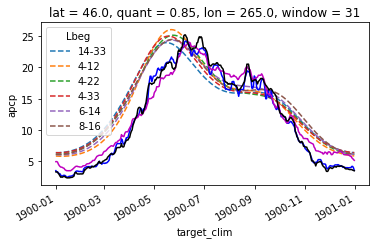

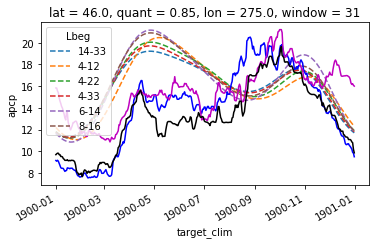

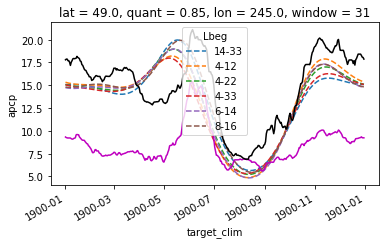

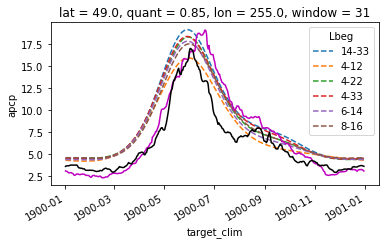

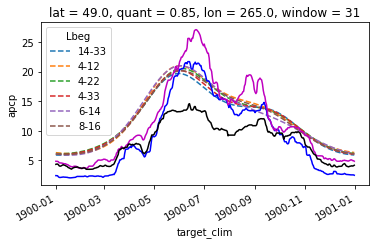

In [136]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        if np.sum(np.isnan(narr_clim_test_3d.where(ds_mask.the_geom>0).apcp[:,:,-1,:,:].sel(lat=ilat, lon=ilon).values))==0:
            plt.figure(figsize=(20,3))
            ax = plt.subplot(131)
            smooth_clim_cauchy.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim')
            cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('b',ax=ax, x='target_clim')
            persiann_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('m',ax=ax, x='target_clim')
            narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('k',ax=ax, x='target_clim')


In [137]:
narr_clim_test_3d

<xarray.Dataset>
Dimensions:      (lat: 28, lon: 71, quant: 5, target_clim: 365, window: 3)
Coordinates:
  * quant        (quant) float64 0.15 0.33 0.5 0.667 0.85
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * window       (window) int64 7 15 31
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    apcp         (target_clim, window, quant, lat, lon) float64 3.24 ... 3.94

In [138]:
smooth_clim_cauchy

<xarray.Dataset>
Dimensions:      (Lbeg: 6, lat: 28, lon: 71, target_clim: 365)
Coordinates:
  * Lbeg         (Lbeg) object '14-33' '4-12' '4-22' '4-33' '6-14' '8-16'
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, lat, lon) float64 ...

In [ ]:
np.corrcoef(

In [153]:
np.correlate(dsin.pr_sfc,dsin.apcp)

NameError: name 'dsin' is not defined

In [160]:
def correlate_target_clim(dsin):
    if np.sum(np.isnan(dsin.pr_sfc))==0:
        out = np.corrcoef(dsin.pr_sfc,dsin.apcp)
        out=out[0][1]
    else:
        out=np.nan
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(out)


In [217]:
corr_narr =[]
for il in np.arange(0,6):
    corr_narri = []
    for iw in np.arange(0,3):
        stack_f = smooth_clim_cauchy.isel(Lbeg=il).stack(allpoints=['lat','lon'])  
        stack_o = narr_clim_test_3d.isel(window=iw).isel(quant=4).stack(allpoints=['lat','lon']) 
        ds_stack = xr.merge((stack_f, stack_o))
        corr_clim = ds_stack.groupby('allpoints').apply(correlate_target_clim)
        corr_clim_map = corr_clim.unstack('allpoints')
        corr_clim_map = corr_clim_map.expand_dims('Lbeg')
        corr_clim_map = corr_clim_map.expand_dims('quant')
        corr_clim_map = corr_clim_map.expand_dims('window')
        corr_narri.append(corr_clim_map)
    corr_narri = xr.concat(corr_narri,dim='window')
    corr_narr.append(corr_narri)
corr_narr = xr.concat(corr_narr, dim='Lbeg')


In [192]:
corr_cpc =[]
for il in np.arange(0,6):
    corr_cpci = []
    for iw in np.arange(0,3):
        stack_f = smooth_clim_cauchy.isel(Lbeg=il).stack(allpoints=['lat','lon'])  
        stack_o = cpc_clim_test_3d.isel(window=iw).isel(quant=4).stack(allpoints=['lat','lon']) 
        ds_stack = xr.merge((stack_f, stack_o))
        corr_clim = ds_stack.groupby('allpoints').apply(correlate_target_clim)
        corr_clim_map = corr_clim.unstack('allpoints')
        corr_clim_map = corr_clim_map.expand_dims('Lbeg')
        corr_clim_map = corr_clim_map.expand_dims('quant')
        corr_clim_map = corr_clim_map.expand_dims('window')
        corr_cpci.append(corr_clim_map)
    corr_cpci = xr.concat(corr_cpci,dim='window')
    corr_cpc.append(corr_cpci)
corr_cpc = xr.concat(corr_cpc, dim='Lbeg')


In [219]:
corr_persiann =[]
for il in np.arange(0,6):
    corr_persianni = []
    for iw in np.arange(0,3):
        stack_f = smooth_clim_cauchy.isel(Lbeg=il).stack(allpoints=['lat','lon'])  
        stack_o = persiann_clim_test_3d.isel(window=iw).isel(quant=4).stack(allpoints=['lat','lon']) 
        ds_stack = xr.merge((stack_f, stack_o))
        corr_clim = ds_stack.groupby('allpoints').apply(correlate_target_clim)
        corr_clim_map = corr_clim.unstack('allpoints')
        corr_clim_map = corr_clim_map.expand_dims('Lbeg')
        corr_clim_map = corr_clim_map.expand_dims('quant')
        corr_clim_map = corr_clim_map.expand_dims('window')
        corr_persianni.append(corr_clim_map)
    corr_persianni = xr.concat(corr_persianni,dim='window')
    corr_persiann.append(corr_persianni)
corr_persiann = xr.concat(corr_persiann, dim='Lbeg')



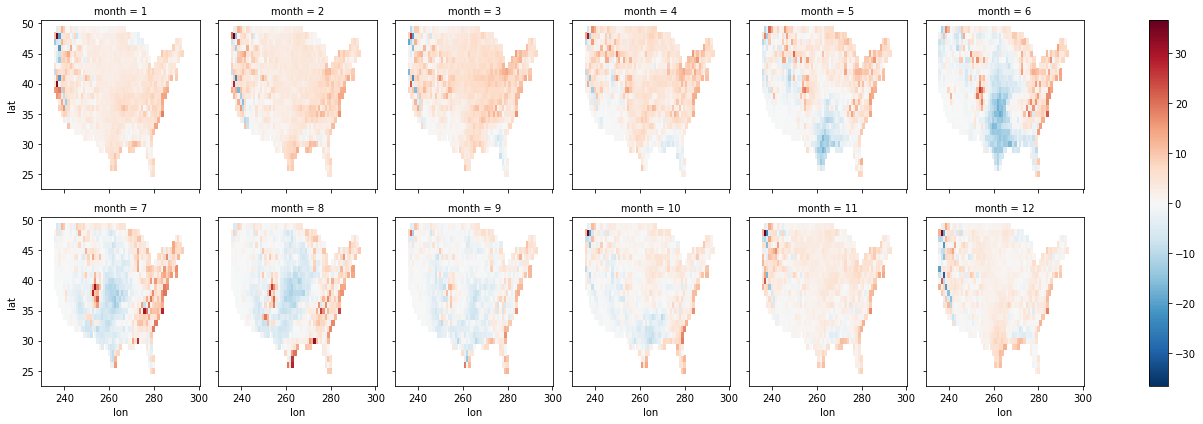

In [214]:
Ads = smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).groupby('target_clim.month').mean()
Bds = narr_clim_test_3d.apcp.isel(quant=4).isel(window=2).groupby('target_clim.month').mean()

(Ads-Bds).plot(col='month',col_wrap=6, cmap='RdBu_r')

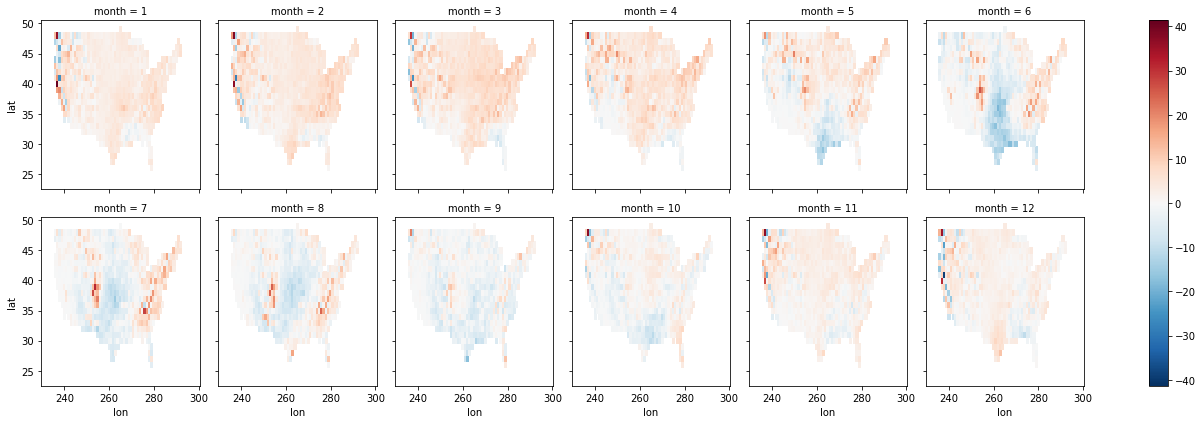

In [215]:
Ads = smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).groupby('target_clim.month').mean()
Bds = cpc_clim_test_3d.apcp.isel(quant=4).isel(window=2).groupby('target_clim.month').mean()

(Ads-Bds).plot(col='month',col_wrap=6, cmap='RdBu_r')

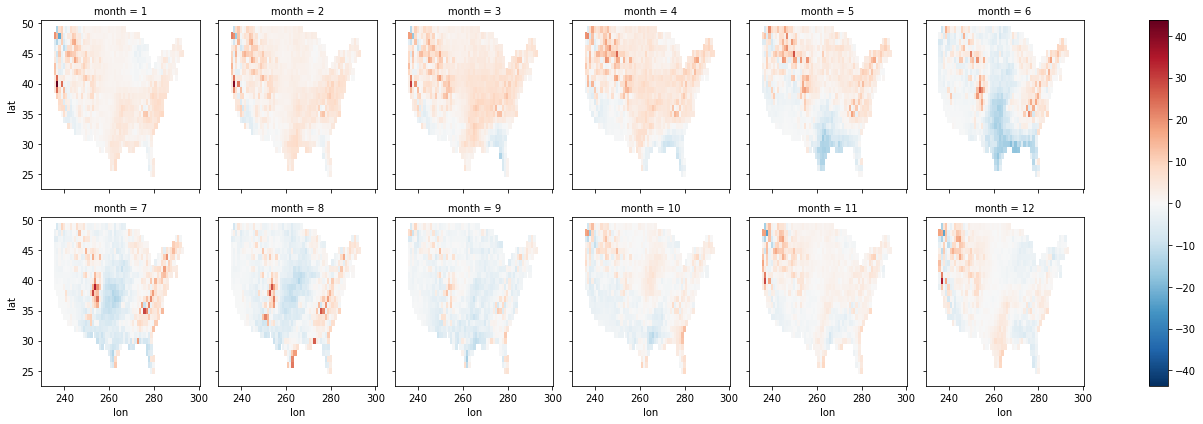

In [216]:
Ads = smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).groupby('target_clim.month').mean()
Bds = persiann_clim_test_3d.apcp.isel(quant=4).isel(window=2).groupby('target_clim.month').mean()

(Ads-Bds).plot(col='month',col_wrap=6, cmap='RdBu_r')

In [174]:
corr_cpc

[<xarray.DataArray (window: 1, quant: 1, Lbeg: 1, lat: 28, lon: 71)>
 array([[[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]]]])
 Coordinates:
   * Lbeg     (Lbeg) <U5 '14-33'
   * quant    (quant) float64 0.85
   * window   (window) int64 7
   * lat      (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 46.0 47.0 48.0 49.0 50.0
   * lon      (lon) float64 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0,
 <xarray.DataArray (window: 1, quant: 1, Lbeg: 1, lat: 28, lon: 71)>
 array([[[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, 

In [184]:
corr_narr2 = xr.combine_nested(corr_narr, concat_dim=['Lbeg'])

In [286]:
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE1_50M_SR_W.zip

--2020-08-24 16:37:49--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE1_50M_SR_W.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 66.147.242.194
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|66.147.242.194|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://naciscdn.org/naturalearth/50m/raster/NE1_50M_SR_W.zip [following]
--2020-08-24 16:37:50--  http://naciscdn.org/naturalearth/50m/raster/NE1_50M_SR_W.zip
Resolving naciscdn.org (naciscdn.org)... 146.201.97.163
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://naciscdn.org/naturalearth/50m/raster/NE1_50M_SR_W.zip [following]
--2020-08-24 16:37:51--  https://naciscdn.org/naturalearth/50m/raster/NE1_50M_SR_W.zip
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:443... connected.
HTTP request sent, awai

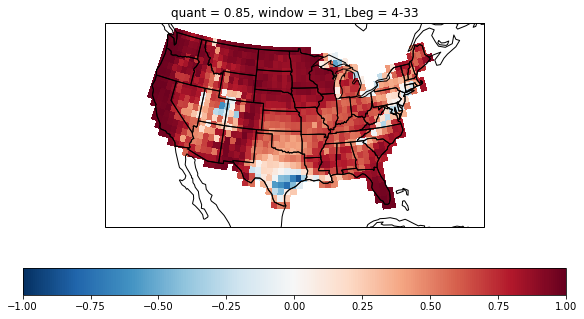

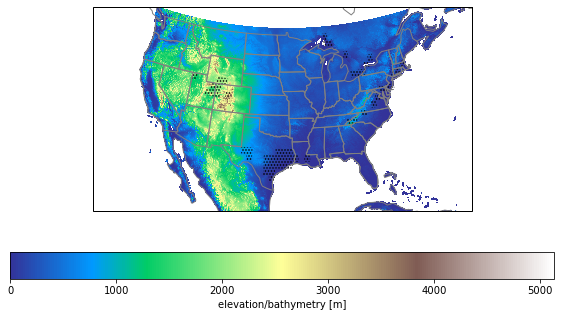

In [341]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45) )

corr_narr.isel(quant=0).isel(window=2).isel(Lbeg=3).plot(vmax=1, zorder=-1, transform=ccrs.PlateCarree(),
                    cbar_kwargs=dict(orientation='horizontal', fraction=0.1))
ax.coastlines()
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS)
ax.add_geometries(
shpreader.Reader(states_shp).geometries(),
ccrs.PlateCarree(),
facecolor='none', edgecolor='k')
#         ax.stock_img(name='ne_shaded')

plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45) )

bath = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO2v2/.z/X/-125/-55/RANGEEDGES/Y/15/50/RANGEEDGES/0/masklt/dods')
bath.z.plot(ax=ax, cmap='terrain', transform=ccrs.PlateCarree(),
                    cbar_kwargs=dict(orientation='horizontal', fraction=0.1))
shaded = corr_narr.isel(quant=0).isel(window=2).isel(Lbeg=3)
ax.pcolor(shaded.lon.values, shaded.lat.values, shaded.where(shaded<=0).values, alpha=0,
               hatch='....',
             transform=ccrs.PlateCarree())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.coastlines(color='gray');

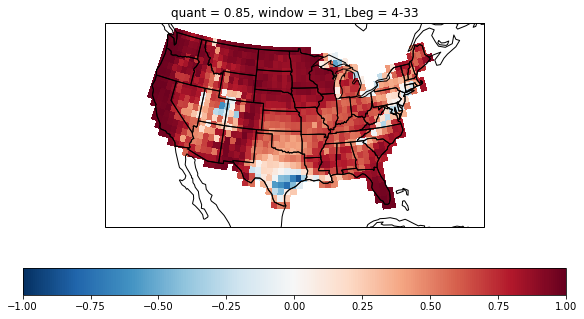

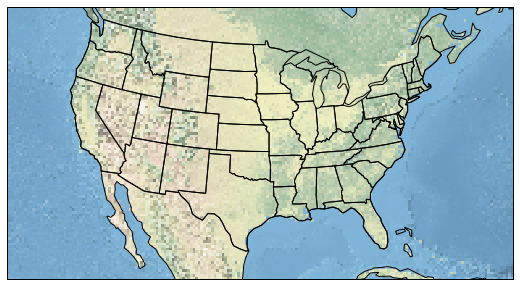

In [295]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from matplotlib.image import imread




plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45) )
ax.imshow(imread('NE1_50M_SR_W/NE1_50M_SR_W.tif'), origin='upper', transform=ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90])
# ax.stock_img()
ax.coastlines()
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS)
ax.add_geometries(
shpreader.Reader(states_shp).geometries(),
ccrs.PlateCarree(),
facecolor='none', edgecolor='k')
#        

In [299]:
# import matplotlib.pyplot as plt
# from matplotlib.transforms import offset_copy

# import cartopy.crs as ccrs
# import cartopy.io.img_tiles as cimgt


# def main():
#     # Create a Stamen terrain background instance.
#     stamen_terrain = cimgt.Stamen('terrain-background')

#     fig = plt.figure()

#     # Create a GeoAxes in the tile's projection.
#     ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

#     # Limit the extent of the map to a small longitude/latitude range.
#     ax.set_extent([-125, -66.5, 20, 50], crs=ccrs.Geodetic())

#     # Add the Stamen data at zoom level 8.
#     ax.add_image(stamen_terrain, 8)

#     # Add a marker for the Eyjafjallajökull volcano.

#     # Use the cartopy interface to create a matplotlib transform object
#     # for the Geodetic coordinate system. We will use this along with
#     # matplotlib's offset_copy function to define a coordinate system which
#     # translates the text by 25 pixels to the left.
#     geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    
#     ax.coastlines()
#     ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
#     ax.add_feature(cfeature.BORDERS)
#     ax.add_geometries(
#     shpreader.Reader(states_shp).geometries(),
#     ccrs.PlateCarree(),
#     facecolor='none', edgecolor='k')
    
#     plt.show()


# if __name__ == '__main__':
#     main()

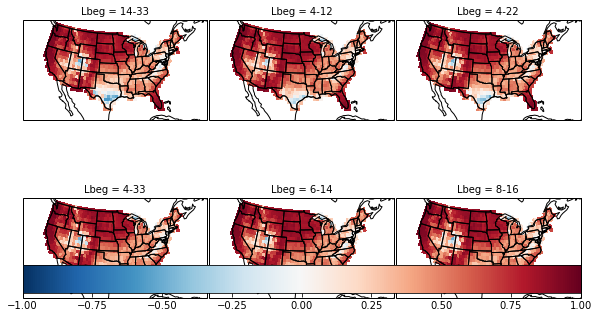

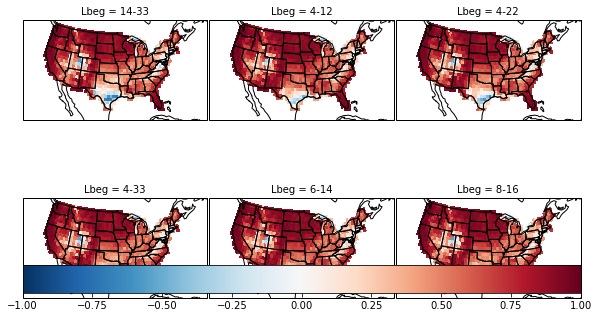

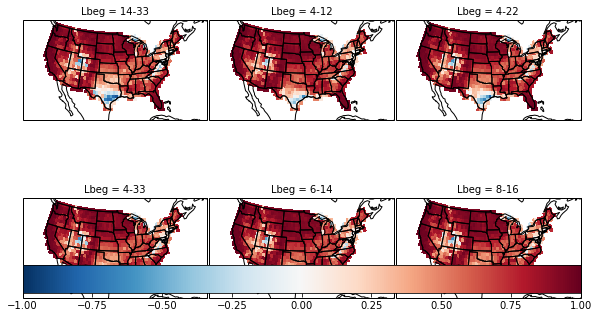

In [277]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
for iw in np.arange(0,3):
    g = corr_narr.isel(quant=0).isel(window=iw).plot(col='Lbeg', col_wrap=3, vmax=1, zorder=-1, transform=ccrs.PlateCarree(),
                    subplot_kws=dict(projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45)),
                    cbar_kwargs=dict(orientation='horizontal', fraction=0.1))
    plt.subplots_adjust(wspace=0.01,hspace=0.2)
    for i, ax in enumerate(g.axes.flat):
        ax.coastlines()
        ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
        ax.add_feature(cfeature.BORDERS)
        ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        facecolor='none', edgecolor='k')
#         ax.stock_img(name='ne_shaded')

        

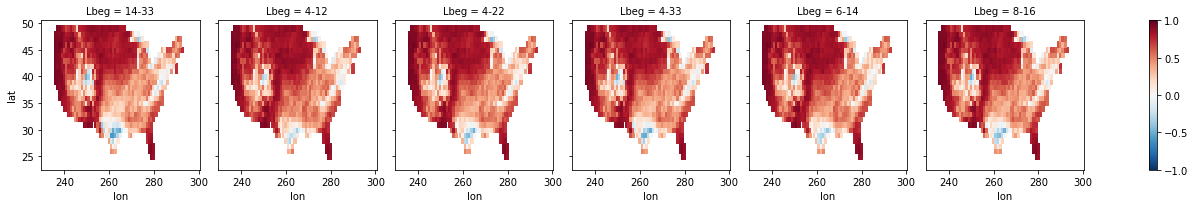

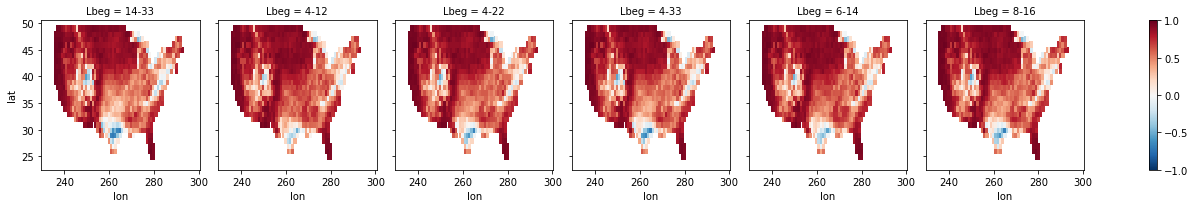

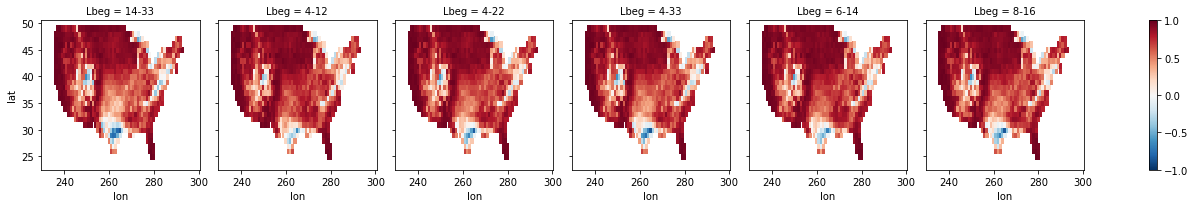

In [218]:
for iw in np.arange(0,3):
    corr_narr.isel(quant=0).isel(window=iw).plot(col='Lbeg', col_wrap=6, vmax=1)

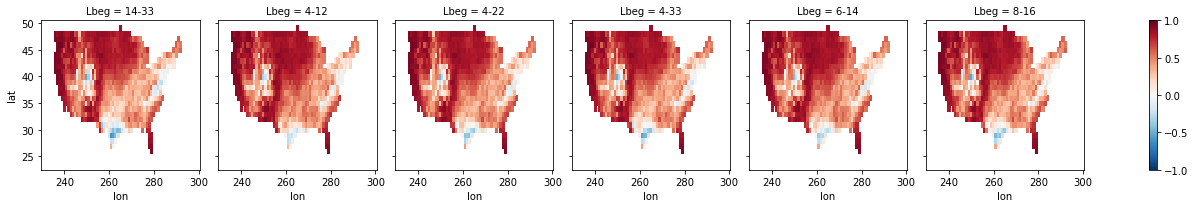

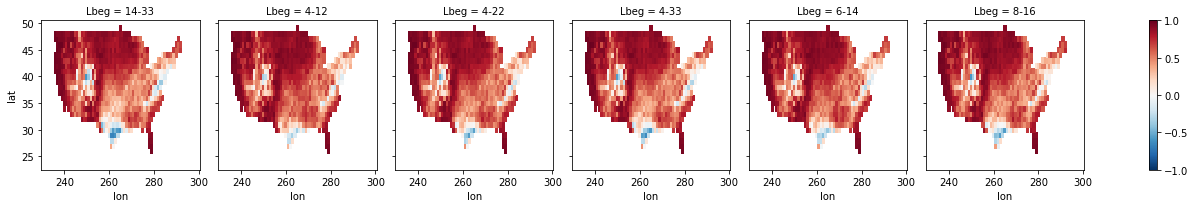

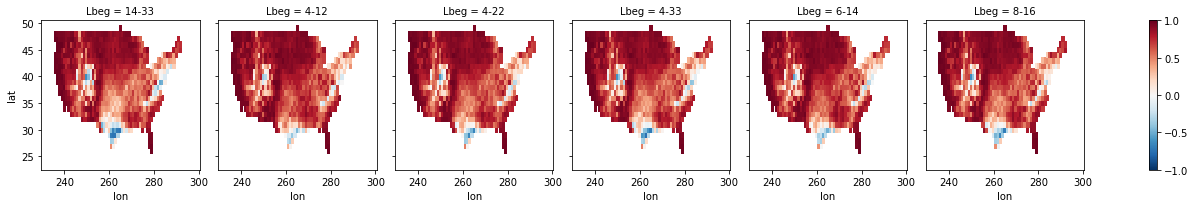

In [205]:
for iw in np.arange(0,3):
    corr_cpc.isel(quant=0).isel(window=iw).plot(col='Lbeg', col_wrap=6, vmax=1)

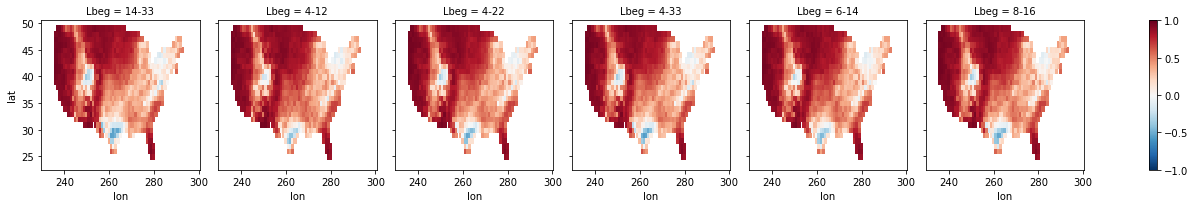

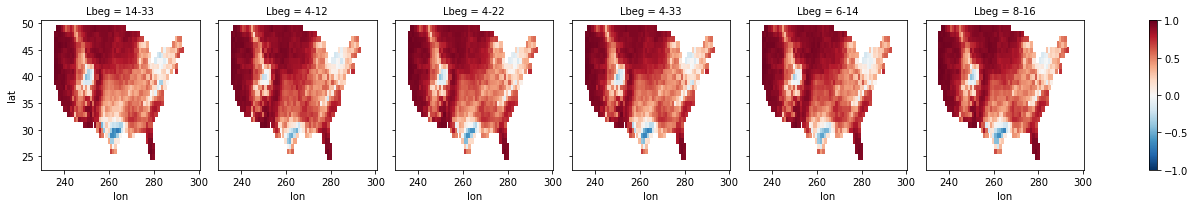

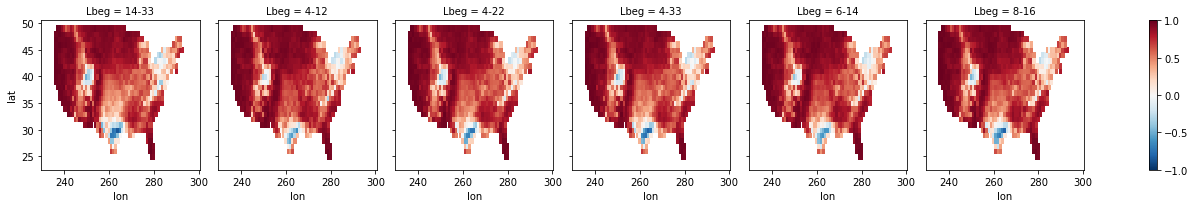

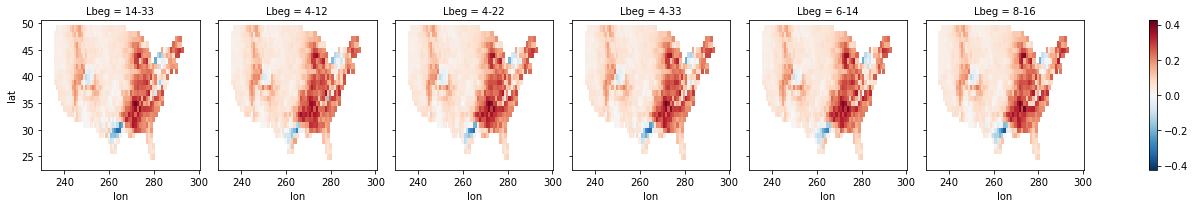

In [220]:
for iw in np.arange(0,3):
    corr_persiann.isel(quant=0).isel(window=iw).plot(col='Lbeg', col_wrap=6, vmax=1)
(corr_persiann.isel(quant=0).isel(window=2)-corr_persiann.isel(quant=0).isel(window=0)).plot(col='Lbeg', col_wrap=6)


In [227]:
ds_clim_test_3d_all = xr.open_dataset('ds_clim_test_3d_all_aug2020.nc')

In [232]:
ds_clim_test_3d_all.isel(Lbeg=3).sel(lat=ilat, lon=ilon)

<xarray.Dataset>
Dimensions:      (quantile: 5, target_clim: 365)
Coordinates:
  * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
    lon          float32 300.0
    lat          float32 50.0
    Lbeg         <U4 '4-33'
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, quantile) float64 ...

In [233]:
cpc_clim_test_3d

<xarray.Dataset>
Dimensions:      (lat: 28, lon: 71, quant: 5, target_clim: 365, window: 3)
Coordinates:
  * quant        (quant) float64 0.15 0.33 0.5 0.667 0.85
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * window       (window) int64 7 15 31
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    apcp         (target_clim, window, quant, lat, lon) float64 0.0 0.0 ... 0.0

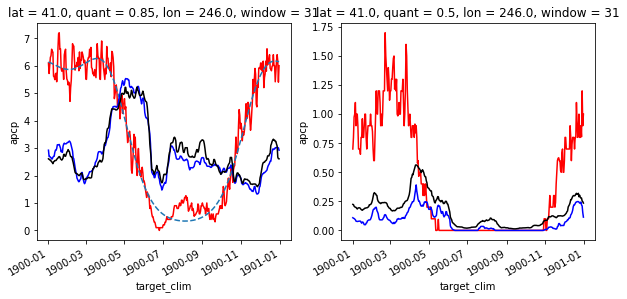

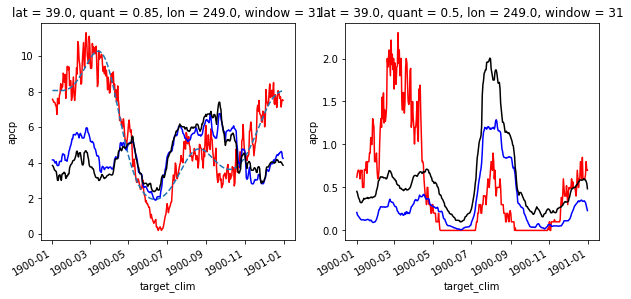

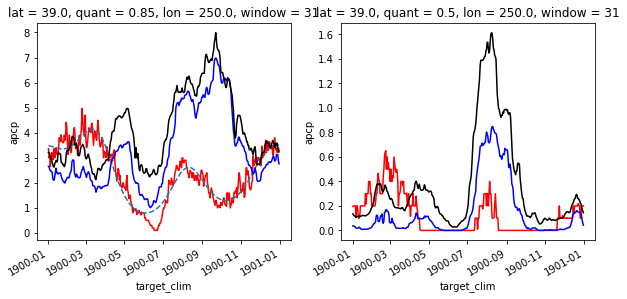

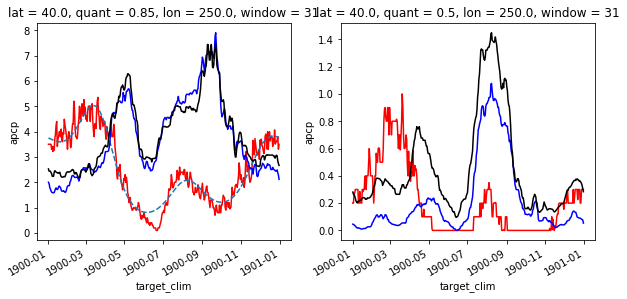

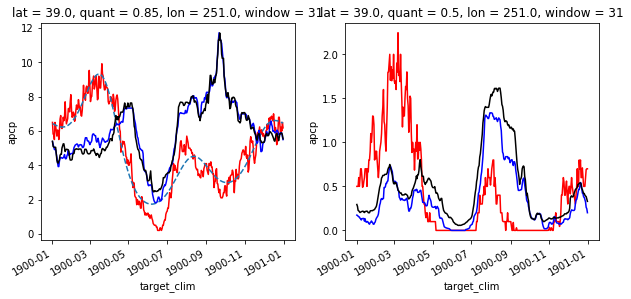

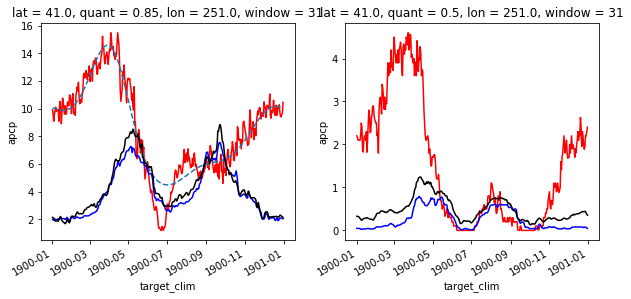

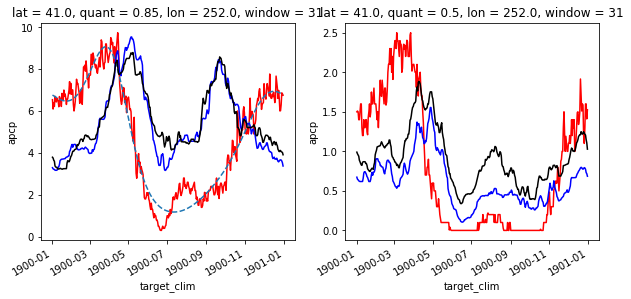

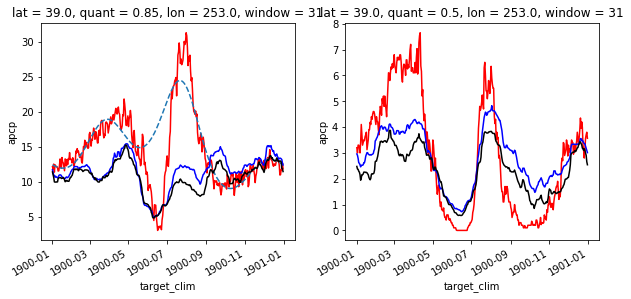

In [235]:
maskcorr = corr_narr.isel(quant=0).isel(window=2).isel(Lbeg=3)
for ilon in maskcorr.lon.values:
    for ilat in maskcorr.lat.values:
        if (ilat>35)&(ilon<260):
            if maskcorr.sel(lat=ilat, lon=ilon)<0:
                plt.figure(figsize=(10,4))
                ax = plt.subplot(121)
                ds_clim_test_3d_all.pr_sfc.isel(Lbeg=3).isel(quantile=4).sel(lat=ilat, lon=ilon).plot.line('r',x='target_clim',ax=ax)
                smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim',ax=ax)
                cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('b',ax=ax, x='target_clim')
        #             persiann_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('m',ax=ax, x='target_clim')
                narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('k',ax=ax, x='target_clim')
                ax = plt.subplot(122)
                ds_clim_test_3d_all.pr_sfc.isel(Lbeg=3).isel(quantile=2).sel(lat=ilat, lon=ilon).plot.line('r',x='target_clim',ax=ax)
        #             smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim',ax=ax)
                cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=2).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('b',ax=ax, x='target_clim')
        #             persiann_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('m',ax=ax, x='target_clim')
                narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=2).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('k',ax=ax, x='target_clim')
            


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


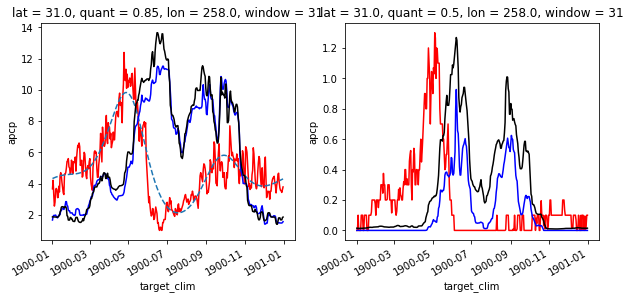

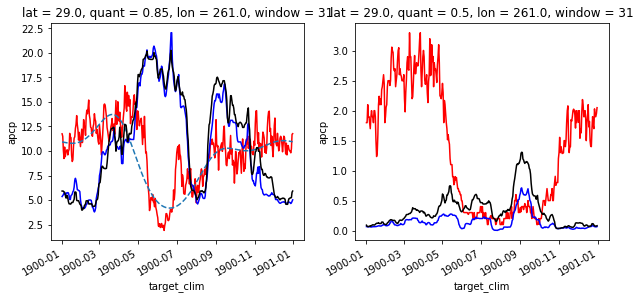

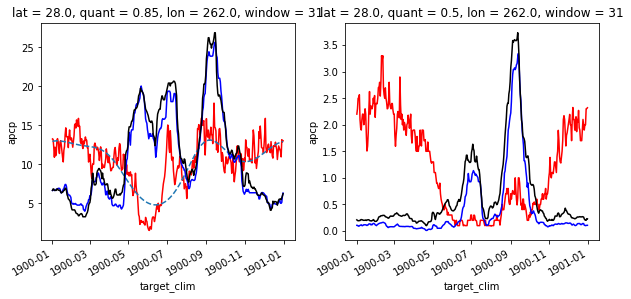

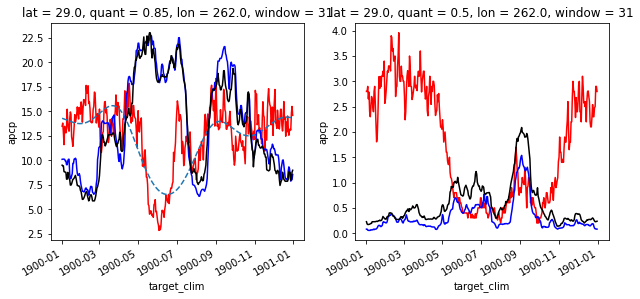

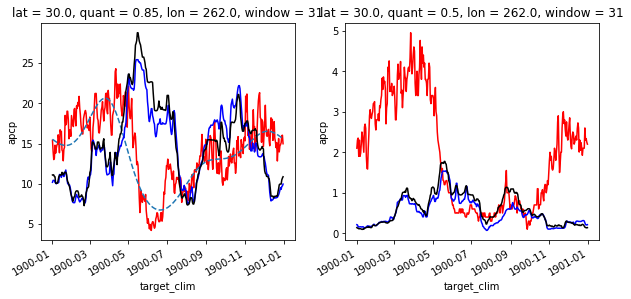

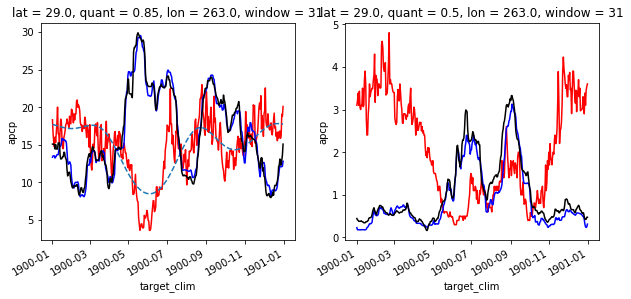

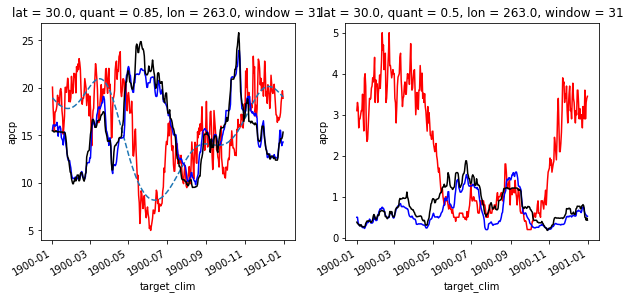

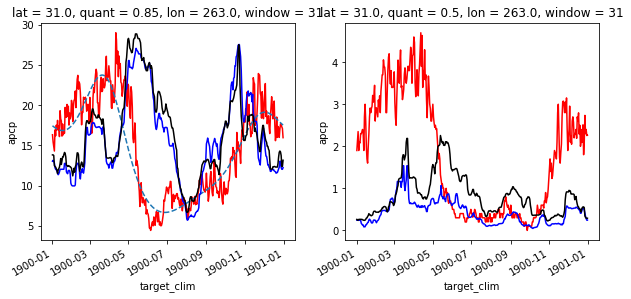

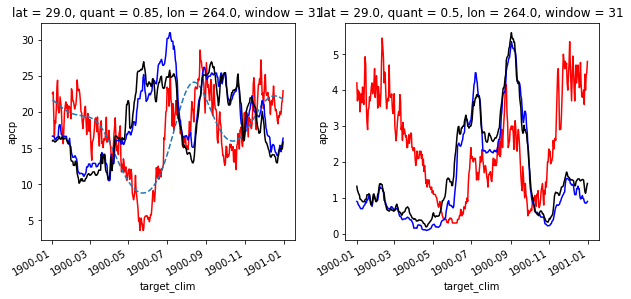

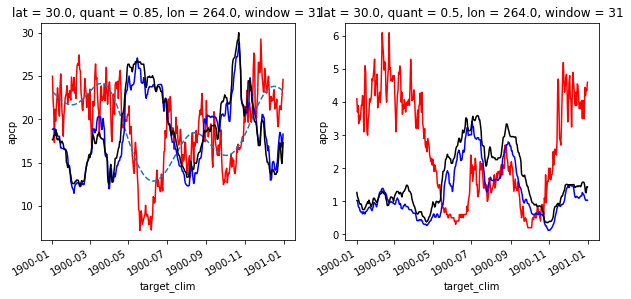

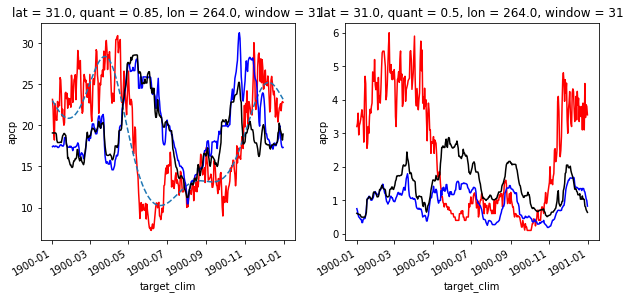

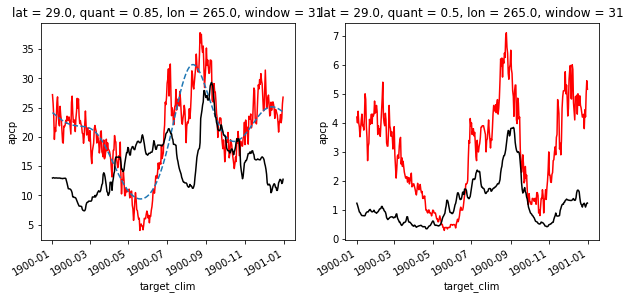

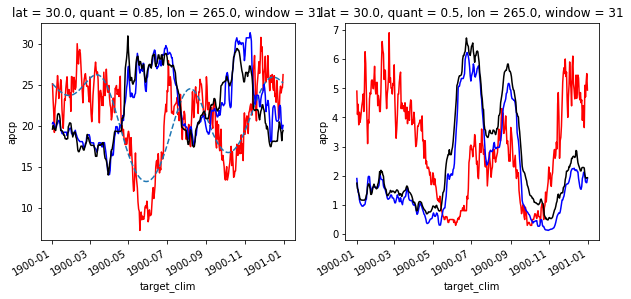

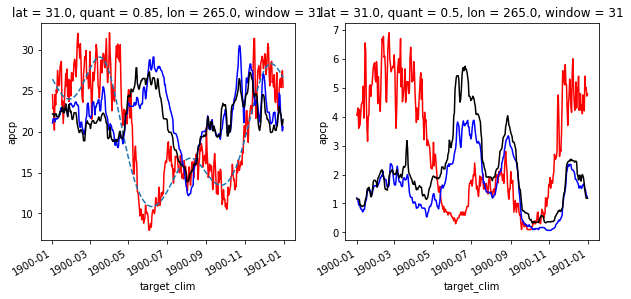

In [236]:
maskcorr = corr_narr.isel(quant=0).isel(window=2).isel(Lbeg=3)
for ilon in maskcorr.lon.values:
    for ilat in maskcorr.lat.values:
        if (ilat<35)&(ilon<270):
            if maskcorr.sel(lat=ilat, lon=ilon)<0:
                plt.figure(figsize=(10,4))
                ax = plt.subplot(121)
                ds_clim_test_3d_all.pr_sfc.isel(Lbeg=3).isel(quantile=4).sel(lat=ilat, lon=ilon).plot.line('r',x='target_clim',ax=ax)
                smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim',ax=ax)
                cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('b',ax=ax, x='target_clim')
        #             persiann_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('m',ax=ax, x='target_clim')
                narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('k',ax=ax, x='target_clim')
                ax = plt.subplot(122)
                ds_clim_test_3d_all.pr_sfc.isel(Lbeg=3).isel(quantile=2).sel(lat=ilat, lon=ilon).plot.line('r',x='target_clim',ax=ax)
        #             smooth_clim_cauchy.pr_sfc.isel(Lbeg=3).sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim',ax=ax)
                cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=2).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('b',ax=ax, x='target_clim')
        #             persiann_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('m',ax=ax, x='target_clim')
                narr_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=2).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('k',ax=ax, x='target_clim')
            


In [225]:
cpc_clim_test_3d.apcp.where(ds_mask.the_geom>0).isel(quant=4).isel(window=2).sel(lat=ilat, lon=ilon).plot.line('b',ax=ax, x='target_clim')


In [ ]:
(corr_persiann.isel(quant=0).isel(window=2)-corr_persiann.isel(quant=0).isel(window=0)).plot(col='Lbeg', col_wrap=6)
